# Importing the required libraries
<p style="font-size: 16px; color: #22b2a3;">
    In the first section, the data is read from the provided CSV file. This is a critical first step where the dataset is loaded into a Pandas DataFrame, allowing us to manipulate and explore the data further.
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import catboost as cb
import optuna
from sklearn.model_selection import StratifiedKFold
import warnings


In [2]:
# Ignore all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
original = pd.read_csv('/kaggle/input/ps4e9-original-data-loan-approval-prediction/credit_risk_dataset.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

## Combining the datasets: 
<p style="font-size: 16px; color: #22b2a3;">
    The next step involves combining different datasets and handling any missing values. Handling missing data is essential to ensure model performance is not impacted by NaN values. In this case, we handle missing values by either imputing them with statistical measures or dropping them. Proper handling of these values can improve model generalization and avoid bias.
</p>


In [4]:
# Combine original and train datasets to create a more robust training set
combined_train = pd.concat([train, original], axis=0).reset_index(drop=True)

In [5]:
combined_train.drop('id', inplace=True, axis=1, errors='ignore')

## Handling missing values:

In [6]:
# Handle missing values
combined_train['person_emp_length'].fillna(combined_train['person_emp_length'].median(), inplace=True)
combined_train['loan_int_rate'].fillna(combined_train['loan_int_rate'].median(), inplace=True)

In [7]:
# Define numerical and categorical features
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

In [8]:
np.bincount(combined_train['loan_status'])

array([75768, 15458])

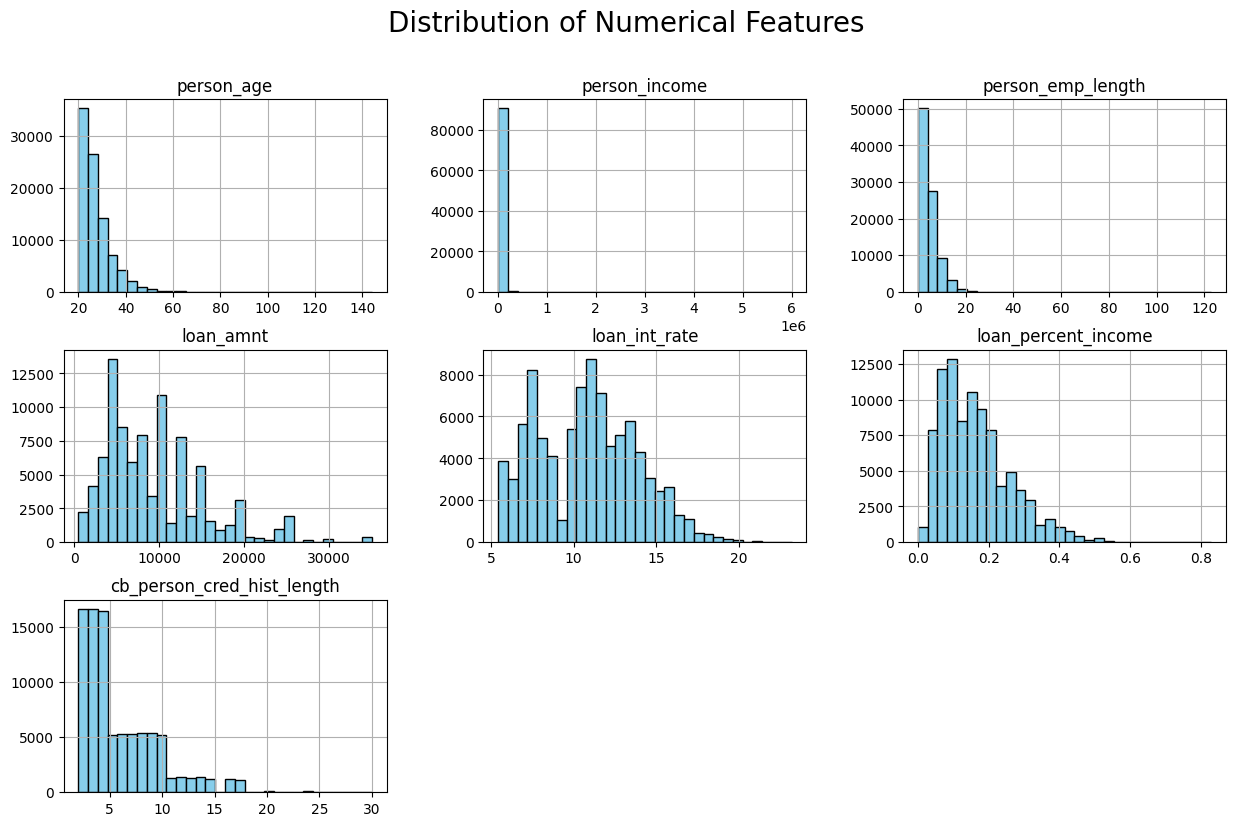

In [9]:
combined_train[numerical_features].hist(bins=30, figsize=(15,9), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=20)
plt.show()

## Scaling the features:
<h3 style="font-size: 18px; color: #c92966;">Scaling the Data</h3>
<p style="font-size: 16px; color: #22b2a3;">
    Scaling is a critical step in preprocessing, especially when features have different ranges. In this project, both <span style="color: #3498db;">log transformation</span> and <span style="color: #3498db;">Z-score normalization</span> are applied to various numerical features.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    The <span style="color: #3498db;">log transformation</span> is used to handle skewed data. Many financial datasets, including fraud detection datasets, have features like transaction amounts that can vary significantly, with a few extreme values (outliers). Applying a <span style="color: #3498db;">log transformation</span> compresses the range of the data, reducing the impact of these outliers and making the distribution more symmetric (closer to a normal distribution). This is especially useful for algorithms that assume normality or perform better when features are normally distributed.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    Additionally, <span style="color: #3498db;">Z-score normalization</span> (also known as standardization) is applied to some features. This method transforms the data so that it has a mean of 0 and a standard deviation of 1. This is crucial when different features have different units or scales. By applying <span style="color: #3498db;">Z-score normalization</span>, we ensure that no feature dominates others simply because of its scale, helping models like <span style="color: #3498db;">CatBoost</span> converge faster and perform better. For instance, transaction amounts and time intervals may vary greatly, and normalizing them helps balance their influence in the model.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    Without proper scaling, models could be skewed towards features with larger magnitudes, leading to biased predictions. In this project, the combination of <span style="color: #3498db;">log transformation</span> and <span style="color: #3498db;">Z-score normalization</span> ensures that the numerical data is prepared in a way that optimizes model performance.
</p>


In [10]:
# Log transformation for skewed numerical features
for feature in ['person_income', 'loan_amnt', 'loan_percent_income']:
    combined_train[feature] = combined_train[feature].apply(lambda x: np.log1p(x) if x > 0 else 0)

# Apply Z-score scaling to numerical features
scaler = StandardScaler()
combined_train[numerical_features] = scaler.fit_transform(combined_train[numerical_features])

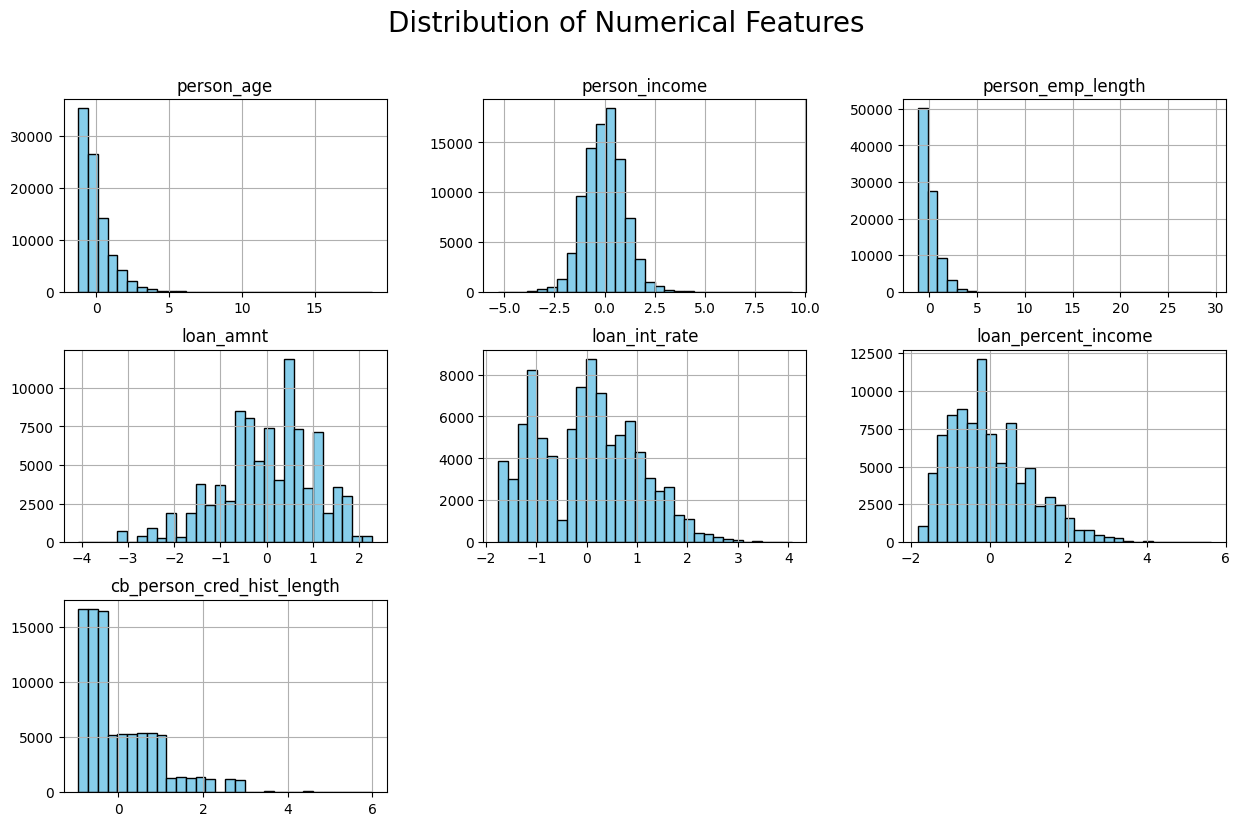

In [11]:
combined_train[numerical_features].hist(bins=30, figsize=(15,9), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=20)
plt.show()

In [12]:
combined_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,1.526252,-0.967395,RENT,-1.179494,EDUCATION,B,-0.362380,0.227457,0.113796,N,2.027982,0
1,-0.913534,-0.025281,OWN,0.318296,MEDICAL,C,-0.969506,0.836184,-0.988318,N,-0.943500,0
2,0.225033,-1.358211,OWN,0.817560,PERSONAL,A,-0.362380,-0.620177,0.528472,N,1.037488,0
3,0.387685,0.422009,RENT,2.315349,VENTURE,B,0.675597,0.103094,0.113796,N,-0.200629,0
4,-0.913534,0.113015,RENT,-0.680230,MEDICAL,A,-0.362380,-1.268176,-0.647223,N,-0.695876,0


## Using label encoding

<h3 style="font-size: 18px; color: #c92966;">Label Encoding</h3>
<p style="font-size: 16px; color: #22b2a3;">
    Label encoding is applied to convert categorical variables into numerical values. In this project, features like <span style="color: #3498db;">loan_intent</span> and <span style="color: #3498db;">loan_grade</span> are encoded, where each unique category is assigned a unique integer.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    For example, <span style="color: #3498db;">loan_intent</span> may include categories such as 'home improvement', 'education', 'personal', etc. Each of these categories is transformed into a number (e.g., 0, 1, 2), which allows the model to process the data effectively. This process is crucial because models like <span style="color: #3498db;">CatBoost</span> require numerical input, not text.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    <span style="color: #3498db;">CatBoost</span> is particularly efficient when dealing with categorical features, as it can handle them natively. Unlike traditional models, which might require extensive one-hot encoding, <span style="color: #3498db;">CatBoost</span>


In [13]:
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    combined_train[feature] = le.fit_transform(combined_train[feature].astype(str))
    label_encoders[feature] = le

In [14]:
combined_train.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

## Splitting the datas and SMOTENC:

<h3 style="font-size: 18px; color: #c92966;">SMOTE: Synthetic Minority Oversampling Technique</h3>
<p style="font-size: 16px; color: #22b2a3;">
    SMOTE (<span style="color: #3498db;">Synthetic Minority Oversampling Technique</span>) is a powerful method for addressing class imbalance in datasets, especially for problems like fraud detection where fraudulent transactions are much fewer than non-fraudulent ones.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    Unlike random oversampling, which duplicates existing minority class instances, <span style="color: #3498db;">SMOTE</span> generates synthetic data points by interpolating between existing minority class examples. Here’s how it works:
</p>

<p style="font-size: 16px; color: #22b2a3;">
    SMOTE first selects a random instance from the minority class. Then, it finds the <span style="color: #3498db;">k-nearest neighbors</span> of this instance based on the feature space. Next, it randomly selects one of these neighbors and creates a synthetic instance by generating a new data point along the line that connects the original instance to the selected neighbor. This process is repeated until the desired balance between classes is achieved.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    The new synthetic data point is not an exact copy of any existing minority class instance, which helps reduce overfitting. By creating these new data points, <span style="color: #3498db;">SMOTE</span> ensures that the model is exposed to a greater variety of fraud examples during training, improving its ability to generalize and detect fraud in unseen data.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    In this project, <span style="color: #3498db;">SMOTE</span> is crucial for dealing with the extreme imbalance between fraudulent and non-fraudulent transactions. Without this technique, the model might struggle to learn meaningful patterns from the few available fraud cases and would likely be biased towards predicting non-fraudulent transactions.
    Smotent is just another version of smote, for datas having categorical features. 
</p>


In [15]:
# Address class imbalance using SMOTENC
X = combined_train.drop('loan_status', axis=1)
y = combined_train['loan_status']

categorical_feature_indices = [X.columns.get_loc(col) for col in categorical_features]
smote_nc = SMOTENC(categorical_features=categorical_feature_indices, sampling_strategy={1: 20000}, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

In [16]:
# Create the resampled training set
train_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['loan_status'])], axis=1)

In [17]:
# Split the data into training and testing sets (e.g., 90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(train_resampled.drop(columns=['loan_status']),
                                                    train_resampled['loan_status'],
                                                    test_size=0.1, random_state=42,
                                                    stratify=train_resampled['loan_status'])

## Model(Catboost): 

<h3 style="font-size: 18px; color: #c92966;">CatBoost Model</h3>
<p style="font-size: 16px; color: #22b2a3;">
    The model chosen for this project is <span style="color: #3498db;">CatBoost</span>, a gradient boosting algorithm specifically designed to handle categorical features efficiently. One of the main reasons for choosing <span style="color: #3498db;">CatBoost</span> is its ability to natively process categorical variables without the need for heavy preprocessing like one-hot encoding, which can increase the dimensionality of the dataset and lead to slower training times.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    <span style="color: #3498db;">CatBoost</span> is highly effective in tasks like fraud detection, where there are imbalanced datasets and complex interactions between features. It builds an ensemble of decision trees, where each tree improves upon the errors made by the previous trees. This helps capture both simple and complex relationships in the data, making <span style="color: #3498db;">CatBoost</span> an excellent choice for this binary classification task.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    One of the strengths of <span style="color: #3498db;">CatBoost</span> is its ability to handle imbalanced datasets. In cases where fraudulent transactions are rare, <span style="color: #3498db;">CatBoost</span> employs regularization techniques that prevent the model from overfitting to the majority class (non-fraudulent transactions). This ensures that the model remains accurate on the minority class (fraudulent transactions), which is the key focus of this project.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    Moreover, <span style="color: #3498db;">CatBoost</span> is designed to handle both categorical and numerical features efficiently, which allows us to feed the model a mix of both types of data without significant preprocessing. Its speed and accuracy make it a great choice for real-world problems like fraud detection, where both precision and recall are critical.
</p>


In [20]:
# Define the objective function for Optuna hyperparameter tuning
def objective(trial):
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'Logloss',  # Changed to Logloss for GPU compatibility
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_seed': 42,
        'verbose': False,
        'early_stopping_rounds': 50
    }
    model = cb.CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        aucs.append(auc)
    return np.mean(aucs)


## Optuna:

<h3 style="font-size: 18px; color: #c92966;">Hyperparameter Tuning with Optuna</h3>
<p style="font-size: 16px; color: #22b2a3;">
    In this project, hyperparameter tuning is performed using <span style="color: #3498db;">Optuna</span>, a state-of-the-art framework that automatically searches for the best hyperparameters by running multiple trials.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    <span style="color: #3498db;">Optuna</span> optimizes key hyperparameters such as <span style="color: #3498db;">learning_rate</span>, <span style="color: #3498db;">depth</span>, and the number of <span style="color: #3498db;">iterations</span>. By evaluating these through various trials, the framework ensures that the model is fine-tuned for both accuracy and generalization, preventing overfitting.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    The best combination of hyperparameters is selected based on metrics like <span style="color: #3498db;">AUC-ROC</span> and <span style="color: #3498db;">F1-score</span>. This step is crucial for improving the model’s performance on the imbalanced dataset, ensuring that both fraudulent and non-fraudulent transactions are classified correctly.
</p>


In [22]:
# Hyperparameter tuning with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Train the final model with the best parameters
best_params = study.best_params
best_params['eval_metric'] = 'Logloss'
best_params['random_seed'] = 42
final_model = cb.CatBoostClassifier(**best_params, task_type='CPU')
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[I 2024-10-17 11:58:51,988] A new study created in memory with name: no-name-9d9012cc-d4ba-48a3-8753-245ee8c214c1
[I 2024-10-17 11:59:55,112] Trial 0 finished with value: 0.9657994359851678 and parameters: {'learning_rate': 0.08507251929756943, 'depth': 6, 'l2_leaf_reg': 0.017317619004338612}. Best is trial 0 with value: 0.9657994359851678.
[I 2024-10-17 12:00:45,911] Trial 1 finished with value: 0.9654355480114395 and parameters: {'learning_rate': 0.12267749929924414, 'depth': 7, 'l2_leaf_reg': 0.06586060811200879}. Best is trial 0 with value: 0.9657994359851678.
[I 2024-10-17 12:02:23,316] Trial 2 finished with value: 0.9656786146690006 and parameters: {'learning_rate': 0.07531151211744062, 'depth': 8, 'l2_leaf_reg': 0.6874059687336329}. Best is trial 0 with value: 0.9657994359851678.
[I 2024-10-17 12:03:34,720] Trial 3 finished with value: 0.9628902276991564 and parameters: {'learning_rate': 0.03414408178196229, 'depth': 6, 'l2_leaf_reg': 3.448540620425936}. Best is trial 0 with val

0:	learn: 0.5099405	test: 0.5124031	best: 0.5124031 (0)	total: 16.7ms	remaining: 16.7s
1:	learn: 0.4025686	test: 0.4067664	best: 0.4067664 (1)	total: 33.4ms	remaining: 16.6s
2:	learn: 0.3410113	test: 0.3465464	best: 0.3465464 (2)	total: 49.3ms	remaining: 16.4s
3:	learn: 0.3038605	test: 0.3102591	best: 0.3102591 (3)	total: 65.4ms	remaining: 16.3s
4:	learn: 0.2810391	test: 0.2876284	best: 0.2876284 (4)	total: 81.4ms	remaining: 16.2s
5:	learn: 0.2644705	test: 0.2705547	best: 0.2705547 (5)	total: 97.9ms	remaining: 16.2s
6:	learn: 0.2530709	test: 0.2596132	best: 0.2596132 (6)	total: 114ms	remaining: 16.2s
7:	learn: 0.2445808	test: 0.2514636	best: 0.2514636 (7)	total: 130ms	remaining: 16.2s
8:	learn: 0.2396295	test: 0.2466053	best: 0.2466053 (8)	total: 145ms	remaining: 16s
9:	learn: 0.2356364	test: 0.2426726	best: 0.2426726 (9)	total: 161ms	remaining: 16s
10:	learn: 0.2330552	test: 0.2403471	best: 0.2403471 (10)	total: 177ms	remaining: 15.9s
11:	learn: 0.2305441	test: 0.2379409	best: 0.23794

## Results:

In [23]:
# Evaluate the model
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Accuracy Score: 0.9482092513313146
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7577
           1       0.95      0.80      0.87      2000

    accuracy                           0.95      9577
   macro avg       0.95      0.89      0.92      9577
weighted avg       0.95      0.95      0.95      9577

Confusion Matrix:
 [[7489   88]
 [ 408 1592]]
ROC-AUC Score: 0.968042233073776


# Test dataset summary :

<h3 style="font-size: 18px; color: #c92966;">Test Dataset Handling</h3>
<p style="font-size: 16px; color: #22b2a3;">
    After the model is trained, it is evaluated on the test dataset, which contains unseen data to assess the model’s generalization performance. The test dataset is kept separate from the training data to ensure that the model is not overfitted to the training set and can generalize well to new data.
</p>

<p style="font-size: 16px; color: #22b2a3;">
    Standard preprocessing steps, such as scaling and label encoding, are applied to the test dataset, ensuring consistency with the training dataset. The model’s performance is measured using metrics such as <span style="color: #3498db;">AUC-ROC</span>, <span style="color: #3498db;">precision</span>, and <span style="color: #3498db;">recall</span> to evaluate how well it predicts both fraudulent and non-fraudulent transactions.
</p>


In [24]:
# Preprocess the test set
# Split the test dataset into ID and other features
test_id = test['id']
test.drop('id', axis=1, inplace=True)

# Apply the same preprocessing steps to the test set
for feature in ['person_income', 'loan_amnt', 'loan_percent_income']:
    test[feature] = test[feature].apply(lambda x: np.log1p(x) if x > 0 else 0)

test[numerical_features] = scaler.transform(test[numerical_features])

for feature in categorical_features:
    test[feature] = label_encoders[feature].transform(test[feature].astype(str))

# Predict the loan status for the test set
predictions_proba = final_model.predict_proba(test)[:, 1]

# Create a DataFrame with ID and prediction probabilities
submission = pd.DataFrame({'id': test_id, 'loan_status': predictions_proba})

# Save the submission DataFrame
submission.to_csv('submission.csv', index=False)

print(" Submission saved")

 Submission saved


In [25]:
submission.head(10)

,id,loan_status
0,58645,0.999916
1,58646,0.035456
2,58647,0.592478
3,58648,0.009760
4,58649,0.029638
5,58650,0.978081
6,58651,0.001186
7,58652,0.007073
8,58653,0.545695
9,58654,0.007659


# Appreciation: 

<p style="font-size: 18px; color: #22b2a3;">
    Thank you for your attention! If this code was helpful to you, please upvote it to help others find it as well.
</p>
<p style="font-size: 16px; color: #22b2a3;">
    If you have any questions, suggestions, or need further clarification, feel free to leave a comment or email me at <a href="mailto:shahbods26@gmail.com">shahbods26@gmail.com</a>.
</p>
